In [1]:
import os

import bayes_net_utils as bn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef, roc_auc_score

%matplotlib inline
plt.style.use("ggplot")

# Introduction

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Generate_hindcasts.ipynb and compare predictions produced using different models to lake observations. 

In [2]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_metno_fpath = '../Data/Predictions/Historic/GBN_prediction_metno_1981-2018_biasadjusted-cyano.csv'
sim_nomet_fpath = '../Data/Predictions/Historic/GBN_prediction_nomet_1981-2018_biasadjusted-cyano.csv'
sim_naive_fpath = '../Data/Predictions/Historic/Prediction_naive_1981-2018.csv'

out_folder = '../Hindcast_stats_plots'

var_list = ['TP', 'chla', 'colour', 'cyano']

# Read in data and reformat

## Observations

In [3]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# Reformat obs to long format, same as the others
obs = pd.melt(
    obs_wide, id_vars=["year"], value_vars=var_list, var_name="node", value_name="obs"
)

obs.tail()

,year,node,obs
151,2015,cyano,0.233
152,2016,cyano,0.166
153,2017,cyano,0.258
154,2018,cyano,0.614
155,2019,cyano,0.592


In [4]:
# Classify the observations

# Dictionary of thresholds to use. N.B. Also defined in bayes_net_utils.R (as boundaries_list)
boundaries_dict = {
    "TP": 29.5,  # Middle of 'Moderate' class
    "chla": 20.0,  # M-P boundary. WFD boundaries: [10.5, 20.0]. Only 6 observed points under 10.5 so merge G & M
    "colour": 48.0,  # 66th percentile (i.e. upper tercile). No management implications
    "cyano": 1.0,  # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho
}

obs_disc = obs.copy()
obs_disc["obs"] = obs[["node", "obs"]].apply(
    lambda x: bn.discretize([boundaries_dict[x.node]], x.obs), axis=1
)
obs_disc.head()

,year,node,obs
0,1981,TP,0.0
1,1982,TP,0.0
2,1983,TP,1.0
3,1984,TP,0.0
4,1985,TP,1.0


## Seasonal naive prediction
i.e. prediction for the current season is the prediction for the previous (corresponding) season

In [5]:
sim_naive_raw = pd.read_csv(sim_naive_fpath)

# Pick out just the expected value
sim_naive = sim_naive_raw[["year", "node", "expected_value"]]
sim_naive.columns = ["year", "node", "sim_naive"]  # Rename columns
print(sim_naive.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_naive_disc = sim_naive_raw[["year", "node", "WFD_class"]]
sim_naive_disc.columns = ["year", "node", "sim_naive"]
print(sim_naive_disc.head(2))

   year node  sim_naive
0  1981   TP  43.573016
1  1982   TP  28.833333
   year node  sim_naive
0  1981   TP        1.0
1  1982   TP        0.0


## BN predictions

In [6]:
# Read in predictions from BN with met nodes, met.no data
sim_metno_raw = pd.read_csv(sim_metno_fpath)

# Pick out just the expected value
sim_metno = sim_metno_raw[["year", "node", "expected_value"]]
sim_metno.columns = ["year", "node", "sim_metno"]  # Rename columns
print(sim_metno.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_metno_class = sim_metno_raw[["year", "node", "WFD_class"]]
sim_metno_class.columns = ["year", "node", "sim_metno"]
print(sim_metno_class.head(2))

   year    node  sim_metno
0  1981    chla       20.0
1  1981  colour       28.0
   year    node  sim_metno
0  1981    chla          1
1  1981  colour          0


In [7]:
# BN predictions, no met nodes
sim_nomet_raw = pd.read_csv(sim_nomet_fpath)

# Pick out just the expected value
sim_nomet = sim_nomet_raw[["year", "node", "expected_value"]]
sim_nomet.columns = ["year", "node", "sim_nomet"]  # Rename columns
print(sim_nomet.head(2))

# Discretized df, including the class prediction
sim_nomet_class = sim_nomet_raw[["year", "node", "WFD_class"]]
sim_nomet_class.columns = ["year", "node", "sim_nomet"]
print(sim_nomet_class.head(2))

   year    node  sim_nomet
0  1981    chla       19.6
1  1981  colour       27.1
   year    node  sim_nomet
0  1981    chla          0
1  1981  colour          0


## Merge observations and predictions from all kinds of model

In [8]:
def merge_model_predictions(df_list):
    df = df_list[0].copy().set_index(["year", "node"])
    for i, new_df in enumerate(df_list):
        new_df = new_df.set_index(["year", "node"])
        if i >= 1:
            df = df.join(new_df)
    df = df.reset_index()
    return df

In [9]:
# Make a dataframe of continuous data (expected values)
df_li = [obs,
         sim_metno,
         sim_nomet,
         sim_naive]

df_cont = merge_model_predictions(df_li)

df_cont.tail()

,year,node,obs,sim_metno,sim_nomet,sim_naive
151,2015,cyano,0.233,0.621,0.778,0.283
152,2016,cyano,0.166,0.850,0.885,0.233
153,2017,cyano,0.258,0.451,0.455,0.166
154,2018,cyano,0.614,0.674,0.768,0.258
155,2019,cyano,0.592,NaN,NaN,0.614


In [10]:
# Merge discretized timeseries into discretized dfs

df_class_list = [
    obs_disc,
    sim_naive_disc,
    sim_metno_class[["year", "node", "sim_metno"]],
    sim_nomet_class[["year", "node", "sim_nomet"]],
]

df_classes = merge_model_predictions(df_class_list)

df_classes.tail()

,year,node,obs,sim_naive,sim_metno,sim_nomet
151,2015,cyano,0.0,0.0,0.0,0.0
152,2016,cyano,0.0,0.0,0.0,0.0
153,2017,cyano,0.0,0.0,0.0,0.0
154,2018,cyano,0.0,0.0,0.0,0.0
155,2019,cyano,0.0,0.0,NaN,NaN


# Plot time series

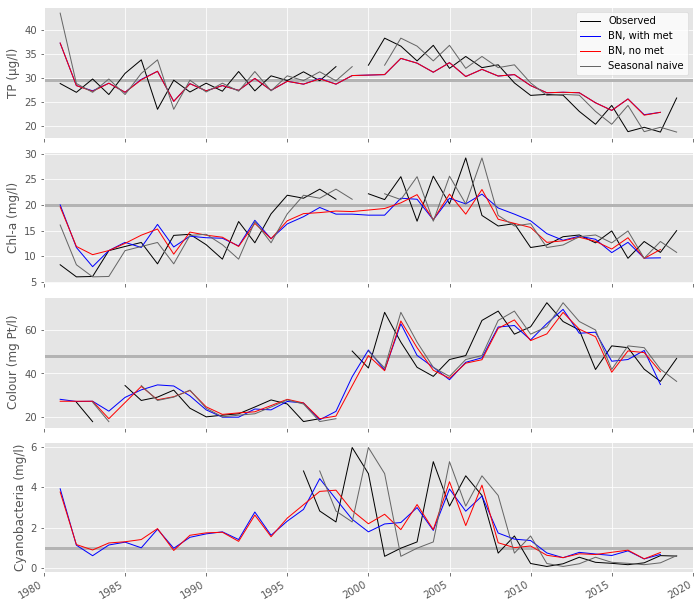

In [11]:
# Setup plot
fig, axes = plt.subplots(nrows=len(var_list),
                         ncols=1,
                         figsize=(10, 10),
                         sharex=True,
                        )

label_dict = {'obs': 'Observed',
              'sim_metno': 'BN, with met',
              'sim_nomet': 'BN, no met',
              'sim_naive': 'Seasonal naive'}

ylabel_dict = {'TP': 'TP (μg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacteria (mg/l)'}

colour_dict = {'obs': 'k',
               'sim_metno': 'b',
               'sim_naive': '0.4',
               'sim_nomet': 'r'}

# Loop over vars
for idx, var in enumerate(var_list):

    # Add WFD boundaries
    axes[idx].axhline(y=boundaries_dict[var], color='0.7', lw=3)

    # Plot observations and predictions
    for col in label_dict.keys():
        var_series = df_cont.loc[df_cont['node'] == var, [col, 'year']]
        var_series = var_series.set_index('year')

        axes[idx].plot(var_series.index,
                       var_series.values,
                       color=colour_dict[col],
                       lw=1,
                       label=label_dict[col]
                      )

    # Tidy
    axes[idx].set_ylabel(ylabel_dict[var])
    axes[idx].set_xlim(xmin=1980, xmax=2020)

    if idx == 0:
        axes[idx].legend(facecolor='white')
#     axes[idx].legend(bbox_to_anchor=(1.35, 1))

plt.tight_layout()
fig.autofmt_xdate()
fpath = os.path.join(out_folder, 'Timeseries_gof', 'timeseries_gof_metno_bias-adj-cyano.png')
plt.savefig(fpath, dpi=300)

# Goodness of fit statistics: simulated vs observed

## Define functions to calculate continuous and discrete GoF stats

In [12]:
def gof_stats(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest
    Input:
        df: with columns 'year', 'node' (variable), 'obs', predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats
    """
    gof_df_dict = {}  # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df["node"] == var]
        df_var = df_var.drop("node", axis=1).set_index("year")
        df_var = df_var.loc[st_yr: end_yr + 1, :]

        cc_li = []
        cc_sp_li = []
        mae_li = []  # mean absolute error
        rmse_li = []
        bias_li = []
        mape_li = []  # mean absolute % error

        for col in sim_cols_of_interest:

            df_test = df_var[[obs_col, col]].dropna()

            errors = df_test[col] - df_test[obs_col]

            cc = df_test[obs_col].corr(df_test[col], method="pearson")
            cc_sp = df_test[obs_col].corr(df_test[col], method="spearman")
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(((errors) ** 2)))
            bias = np.mean(errors)
            mape = np.mean(100 * (errors / df_test[obs_col]))

            cc_li.append(cc)
            cc_sp_li.append(cc_sp)
            mae_li.append(mae)
            rmse_li.append(rmse)
            bias_li.append(bias)
            mape_li.append(mape)

        gof_df = pd.DataFrame(
            list(zip(cc_li, cc_sp_li, mae_li, rmse_li, bias_li, mape_li)),
            columns=["pearsons_cc", "spearman_cc", "mae", "rmse", "bias", "mape"],
            index=sim_cols_of_interest,
        )

        gof_df_dict[var] = gof_df

    gof_df = pd.concat(gof_df_dict.values(), keys=gof_df_dict.keys())

    return gof_df

In [13]:
def gof_stats_classified_data(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest.
    See https://towardsdatascience.com/machine-learning-an-error-by-any-other-name-a7760a702c4d
    for a description of stats calculated,
    as well as the sklearn documentation

    Input:
        df: with columns 'year', 'node' (variable), observed and predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats
    """

    gof_df_disc_dict = {}  # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df["node"] == var]
        df_var = df_var.drop("node", axis=1).set_index("year")
        df_var = df_var.loc[st_yr: end_yr + 1, :]

        mcc_li = []  # Matthews correlation coefficient
        roc_li = []  # ROC
        ce_li = []  # Classification error

        for col in sim_cols_of_interest:

            test_df = df_var[[obs_col, col]].dropna()

            mcc = matthews_corrcoef(test_df[obs_col].values, test_df[col].values)
            rocs = roc_auc_score(test_df[obs_col].values, test_df[col].values)
            ce = bn.classification_error(test_df[obs_col], test_df[col])

            mcc_li.append(mcc)
            roc_li.append(rocs)
            ce_li.append(ce)

        gof_df = pd.DataFrame(
            list(zip(mcc_li, roc_li, ce_li)),
            columns=["mathews_cc", "roc_auc_score", "classification_error"],
            index=sim_cols_of_interest,
        )

        gof_df_disc_dict[var] = gof_df

    gof_class_df = pd.concat(gof_df_disc_dict.values(), keys=gof_df_disc_dict.keys())

    return gof_class_df

## Calculate stats

In [14]:
df_classes.head()

,year,node,obs,sim_naive,sim_metno,sim_nomet
0,1981,TP,0.0,1.0,1.0,1.0
1,1982,TP,0.0,0.0,0.0,0.0
2,1983,TP,1.0,0.0,0.0,0.0
3,1984,TP,0.0,1.0,0.0,0.0
4,1985,TP,1.0,0.0,0.0,0.0


In [15]:
obs_col = "obs"
sim_cols = ["sim_naive", "sim_metno", "sim_nomet"]
st_yr = 1981

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(["var", "model"])

gof_df.reset_index().to_csv(
    os.path.join(out_folder, "GoF_sim_vs_obs_%s-2018_bias-adj-cyano.csv" % st_yr),
    index=False,
    float_format="%.3f",
)

gof_df

pearsons_cc  spearman_cc       mae      rmse      bias  \
var    model                                                               
TP     sim_naive     0.636465     0.639165  3.421504  4.387387  0.488460   
       sim_metno     0.646400     0.638396  2.985257  3.679643 -0.056784   
       sim_nomet     0.645768     0.637253  2.985257  3.682326 -0.067594   
chla   sim_naive     0.647769     0.631105  3.613692  4.599624  0.058472   
       sim_metno     0.621598     0.594688  3.538900  4.377578 -0.092722   
       sim_nomet     0.604963     0.588926  3.490474  4.443551 -0.063263   
colour sim_naive     0.849135     0.843249  7.294954  9.207931  0.844530   
       sim_metno     0.866016     0.869090  6.426625  8.406340 -0.516083   
       sim_nomet     0.843621     0.850900  6.871679  9.048065 -0.753226   
cyano  sim_naive     0.563204     0.715415  1.192313  1.759581  0.182957   
       sim_metno     0.593931     0.724308  1.168678  1.538761 -0.019513   
       sim_nomet     0.614165     0.733383  1.181635  1.511173 -0.006730   

                        mape  mathews_cc  roc_auc_score  classification_error  
var    model                                                                   
TP     sim_naive    2.625402    0.180477       0.590774              0.405405  
       sim_metno    1.638654    0.343322       0.669118              0.324324  
       sim_nomet    1.598650    0.343322       0.669118              0.324324  
chla   sim_naive    5.053979    0.706349       0.853175              0.108108  
       sim_metno    8.247853    0.227579       0.594444              0.270270  
       sim_nomet    9.125306    0.180098       0.562963              0.270270  
colour sim_naive    5.532723    0.550848       0.779762              0.212121  
       sim_metno    2.776991    0.371206       0.678322              0.285714  
       sim_nomet    2.706364    0.441351       0.716783              0.257143  
cyano  sim_naive   76.168015    0.564902       0.784615              0.217391  
       sim_metno  125.136308    0.699206       0.833333              0.173913  
       sim_nomet  117.067493    0.699206       0.833333              0.173913